## Estimate outside CaCO3 saturation

In [ ]:
# From Severinghaus Table 2. 
import pandas as pd

fpath = 'simoc_server/test/b2_data_files/severinghaus_carbonation_outside.csv'
df = pd.read_csv(fpath, header=None, names=['depth', 'percent'])
print(df.shape[0], 'measurements')
df.head()
df['depth_0'] = [0] + df.iloc[0:-1, 0].tolist()
df['depth_delta'] = df['depth'] - df['depth_0']
df['area_at_tick'] = df['depth_delta'] * df['percent']
df.plot()
print('Est. outside carbonation per m2:', df['area_at_tick'].sum(), '%')

In [93]:
poured = '1989-07-01'
start_1 = '1991-09-26'
measured = '1993-06-07'
end_1 = '1993-09-25'
start_2 = '1994-03-06'
end_2 = '1994-09-07'
days_pre = pd.date_range(poured, start_1, freq='D').shape[0]
days_meas = pd.date_range(start_1, measured, freq='D').shape[0]
days_m1 = pd.date_range(measured, end_1, freq='D').shape[0]
days_betw = pd.date_range(end_1, start_2, freq='D').shape[0]
days_m2 = pd.date_range(start_2, end_2, freq='D').shape[0]
print(f'Concrete poured {days_pre} days pre-enclosure')
print(f'Measured {days_meas} days after start of enclosure.')

Concrete poured 818 days pre-enclosure
Measured 621 days after start of enclosure.


Carbonation at time of enclosure: 0.004574589316163793


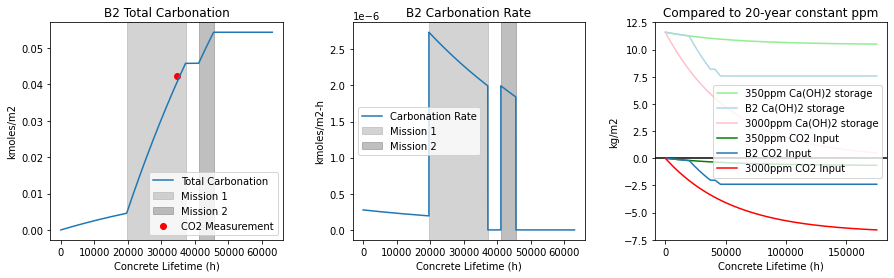

In [186]:
import matplotlib.pyplot as plt
# Assumptions:
# - 100% of outside carbonation occured *prior* to enclosure
# - Diffusion rate proportional to delta between current and max carbonation

molar_mass = dict(o2=15.999, co2=44.01, caoh2=74.093)
class Concrete:
    
    diffusion_rate = .000018         # <-- ADJUST
    saturation_when_measured = 0.3  # <-- ADJUST

    def __init__(self):
        self.age = 0
        self.carbonation_rate = 0  # Current kmoles/h rate
        self.carbonation = 0       # Cumulative kmoles
        
        # Mass of carbonate-able material, i.e. Calcium Hydroxide Ca(OH)2
        self.density = 1.21  # Table 2, 'structural concrete'
        self.density /= 1000  # Convert grams to kg
        
        # Max saturation
        baseline_rate = 12.7  # Estimated from Severinghaus Figure 2
        elevated_rate = baseline_rate + 35 / self.saturation_when_measured  # Table 2
        self.rate_scale = [baseline_rate, elevated_rate]
        self.ppm_range = [350, 3000]
        
        # Exchanges and storages: molar masses, all weighted by carbonation_rate in kmoles
        self.attrs = {'in_co2': 44.01, 'in_caoh2': 74.10, 'out_caco3': 100.09, 'out_h2o': 18.02}
        self.history = {'co2': [], 'caoh2': [], 'caco3': [], 'h2o': [], 'carbonation_rate': [], 'carbonation': []}
        self.co2 = 0
        self.caoh2 = self.calc_max_carbonation(3000) * self.attrs['in_caoh2']
        self.caco3 = 0
        self.h2o = 0
        
    def calc_max_carbonation(self, ppm):
        """Return max kmoles CO2 uptake by structural concrete"""
        saturation_kmoles = np.interp(ppm, self.ppm_range, self.rate_scale)
        return saturation_kmoles * self.density
        
    def step(self, ppm=350):
        self.age += 1
        max_carbonation = self.calc_max_carbonation(ppm)
        gradient = max(0, max_carbonation - self.carbonation)
        rate = gradient * self.diffusion_rate
        self.carbonation_rate = rate

        self.carbonation += rate
        self.co2 -= rate * self.attrs['in_co2']        
        self.caoh2 -= rate * self.attrs['in_caoh2']
        self.caco3 += rate * self.attrs['out_caco3']
        self.h2o += rate * self.attrs['out_h2o']
        for field in {'carbonation_rate', 'carbonation', 'co2', 'caoh2', 'caco3', 'h2o'}:
            self.history[field].append(getattr(self, field))
        
concrete = Concrete()
for i in range(days_pre*24):
    concrete.step()
print('Carbonation at time of enclosure:', concrete.carbonation)
for i in range((days_meas+days_m1)*24):
    concrete.step(3000)
for i in range(days_betw*24):
    concrete.step()
for i in range(days_m2*24):
    concrete.step(3000)
for i in range(365*24*2):
    concrete.step()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plt.subplots_adjust(wspace=.3)
axs[0].plot(range(concrete.age), concrete.history['carbonation'], label='Total Carbonation')
# axs[0].plot(range(concrete.age), concrete.history['caoh2'], label='Calcium Hydroxide')
axs[0].set_xlabel('Concrete Lifetime (h)')
axs[0].set_ylabel('kmoles/m2')
m1_start = days_pre * 24
m1_end = m1_start + (days_meas + days_m1) * 24
m2_start = m1_end + days_betw * 24
m2_end = m2_start + days_m2 * 24
axs[0].axvspan(m1_start, m1_end, alpha=0.5, color='darkgray', label='Mission 1')
axs[0].axvspan(m2_start, m2_end, alpha=0.5, color='gray', label='Mission 2')
axs[0].scatter(x=(days_pre + days_meas)*24, y=550/13000, color='red', label='CO2 Measurement')
axs[0].legend(loc='lower right')
axs[0].set_title('B2 Total Carbonation');

axs[1].plot(range(concrete.age), concrete.history['carbonation_rate'], label='Carbonation Rate')
axs[1].set_xlabel('Concrete Lifetime (h)')
axs[1].set_ylabel('kmoles/m2-h')
axs[1].axvspan(m1_start, m1_end, alpha=0.5, color='darkgray', label='Mission 1')
axs[1].axvspan(m2_start, m2_end, alpha=0.5, color='gray', label='Mission 2')
axs[1].legend(loc='center left')
axs[1].set_title('B2 Carbonation Rate')

concrete_baseline = Concrete()
concrete_elevated = Concrete()
for i in range(365*24*20):
    if i > concrete.age:
        concrete.step()
    concrete_baseline.step()
    concrete_elevated.step(3000)
axs[2].axhline(0, color='black')
axs[2].plot(concrete_baseline.history['caoh2'], label='350ppm Ca(OH)2 storage', color='lightgreen')
axs[2].plot(concrete.history['caoh2'], color='lightblue', label='B2 Ca(OH)2 storage')
axs[2].plot(concrete_elevated.history['caoh2'], label='3000ppm Ca(OH)2 storage', color='pink')
axs[2].plot(concrete_baseline.history['co2'], label='350ppm CO2 Input', color='green')
axs[2].plot(concrete.history['co2'], color='tab:blue', label='B2 CO2 Input')
axs[2].plot(concrete_elevated.history['co2'], label='3000ppm CO2 Input', color='red')
axs[2].set_xlabel('Concrete Lifetime (h)')
axs[2].set_ylabel('kg/m2')
axs[2].legend(loc='center right')
axs[2].set_title('Compared to 20-year constant ppm');